In [ ]:
import json
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import cv2
from typing import List
import numpy as np

In [40]:
class InputStream:
    def __init__(self, data):
        self.data = data
        self.i = 0

    def read(self, size):
        out = self.data[self.i : self.i + size]
        self.i += size
        return int(out, 2)


def access_bit(data, num):
    """from bytes array to bits by num position"""
    base = int(num // 8)
    shift = 7 - int(num % 8)
    return (data[base] & (1 << shift)) >> shift


def bytes2bit(data):
    """get bit string from bytes data"""
    return "".join([str(access_bit(data, i)) for i in range(len(data) * 8)])


def rle_to_mask(rle: List[int], height: int, width: int) -> np.array:
    """
    Converts rle to image mask
    Args:
        rle: your long rle
        height: original_height
        width: original_width

    Returns: np.array
    """

    rle_input = InputStream(bytes2bit(rle))

    num = rle_input.read(32)
    word_size = rle_input.read(5) + 1
    rle_sizes = [rle_input.read(4) + 1 for _ in range(4)]
    # print('RLE params:', num, 'values,', word_size, 'word_size,', rle_sizes, 'rle_sizes')

    i = 0
    out = np.zeros(num, dtype=np.uint8)
    while i < num:
        x = rle_input.read(1)
        j = i + 1 + rle_input.read(rle_sizes[rle_input.read(2)])
        if x:
            val = rle_input.read(word_size)
            out[i:j] = val
            i = j
        else:
            while i < j:
                val = rle_input.read(word_size)
                out[i] = val
                i += 1

    image = np.reshape(out, [height, width, 4])[:, :, 3]
    return image

In [2]:
export_file = pathlib.Path(r"C:\code_ibre\load-simpla-annotations\data\ai_assisted\20250813\stand_2025-08-13.json")
image_dir = pathlib.Path(r"C:\code_ibre\load-simpla-annotations\data\ai_assisted\20250813\images")

In [3]:
with open(export_file, "r") as f:
    labels = json.load(f)

df_labels = pd.DataFrame(labels)

In [25]:
df_labels.head()  # Display the first few rows of the DataFrame

id                                        annotations drafts predictions  \
0  1872  [{'id': 473, 'completed_by': 1, 'result': [], ...     []          []   
1  1873  [{'id': 474, 'completed_by': 1, 'result': [], ...     []          []   
2  1874  [{'id': 475, 'completed_by': 1, 'result': [], ...     []          []   
3  1875  [{'id': 476, 'completed_by': 1, 'result': [], ...     []          []   
4  1876  [{'id': 477, 'completed_by': 1, 'result': [], ...     []          []   

                                                data meta  \
0  {'image': 's3://simpla-gruen-source/Q3052-100c...   {}   
1  {'image': 's3://simpla-gruen-source/Q3052-100w...   {}   
2  {'image': 's3://simpla-gruen-source/Q3052-101c...   {}   
3  {'image': 's3://simpla-gruen-source/Q3052-101w...   {}   
4  {'image': 's3://simpla-gruen-source/Q3052-102....   {}   

                    created_at                   updated_at  inner_id  \
0  2025-07-24T14:35:42.660787Z  2025-07-26T18:58:13.252984Z         1   
1  2025-07-24T14:35:42.680255Z  2025-07-26T19:00:33.845790Z         2   
2  2025-07-24T14:35:42.695213Z  2025-07-26T19:01:00.470113Z         3   
3  2025-07-24T14:35:42.709641Z  2025-07-26T19:01:26.480863Z         4   
4  2025-07-24T14:35:42.723436Z  2025-07-26T19:01:41.840380Z         5   

   total_annotations  cancelled_annotations  total_predictions  comment_count  \
0                  1                      0                  0              0   
1                  1                      0                  0              0   
2                  1                      0                  0              0   
3                  1                      0                  0              0   
4                  1                      0                  0              0   

   unresolved_comment_count last_comment_updated_at  project  updated_by  \
0                         0                    None        2           1   
1                         0                    None        2           1   
2                         0                    None        2           1   
3                         0                    None        2           1   
4                         0                    None        2           1   

  comment_authors  
0              []  
1              []  
2              []  
3              []  
4              []

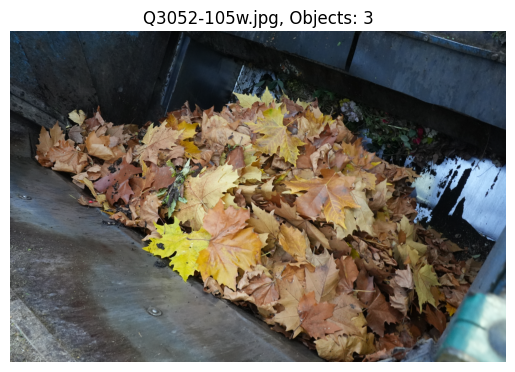

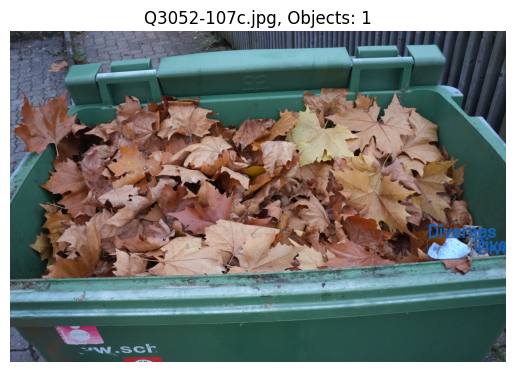

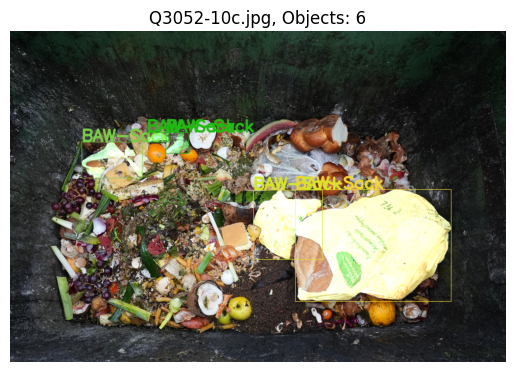

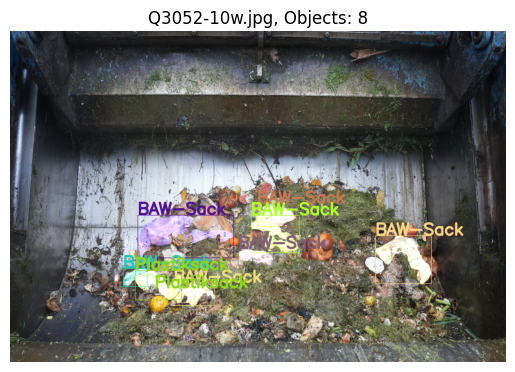

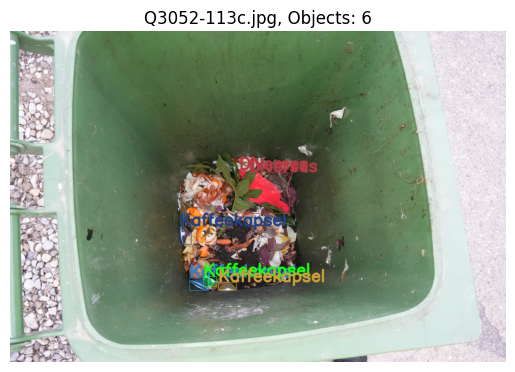

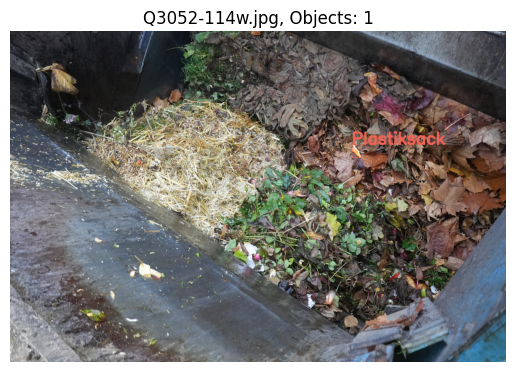

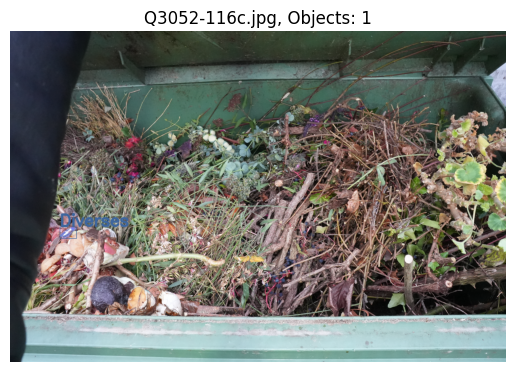

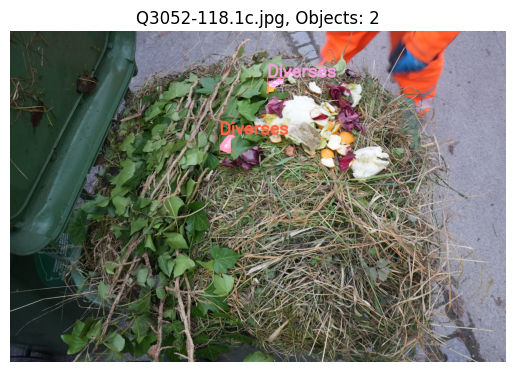

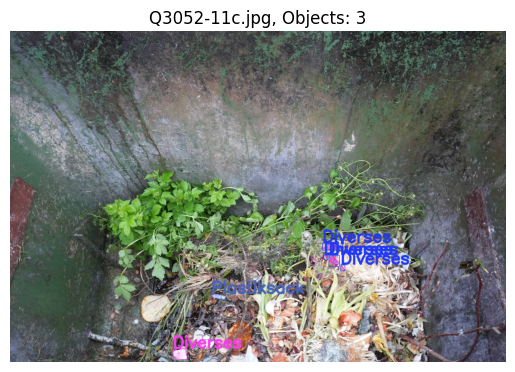

KeyboardInterrupt: 

In [70]:
for data in df_labels[:200].itertuples():
    annotations = data.annotations
    if annotations is None:
        continue  # Skip if there are no annotations
    for annotation in annotations:
        if not annotation.get("result"):
            continue  # Skip if the result is empty or None

        # The following code will execute only for annotations with results
        image_url = data.data.get("image")
        if not image_url:
            continue # Skip if image url is not in data

        image_path = image_dir / image_url.split("/")[-1]
        
        if image_path.exists():
            img = cv2.imread(str(image_path))

            for result in annotation["result"]:
                if result["type"] == "keypointlabels":
                    continue
                value = result.get("value")
                if value.get("format") == "rle":
                    mask = rle_to_mask(value.get("rle"), result.get("original_height"), result.get("original_width"))

                # validate mask before using it
                if mask is None:
                    continue
                if not isinstance(mask, np.ndarray):
                    try:
                        mask = np.asarray(mask)
                    except Exception:
                        continue

                # skip empty masks
                if mask.sum() == 0:
                    continue
                # Create a colored mask in a random color
                colored_mask = np.zeros_like(img)
                color = np.random.randint(0, 256, size=3, dtype=np.uint8)
                colored_mask[mask > 0] = color

                # Blend the original image and the colored mask
                img = cv2.addWeighted(img, 1, colored_mask, 0.5, 0)
                del mask # Clean up mask variable for next iteration

                # derive binary mask from the colored mask (mask was deleted earlier)
                mask_bin = (np.any(colored_mask != 0, axis=2)).astype(np.uint8) * 255

                # find contours (compatibly handle different OpenCV return signatures)
                cnts = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cnts = cnts[0] if len(cnts) == 2 else cnts[1]

                for cnt in cnts:
                    if cv2.contourArea(cnt) < 10:
                        continue
                    x, y, w, h = cv2.boundingRect(cnt)
                    # draw bounding box (green) and an optional label from brushlabels
                    cv2.rectangle(img, (x, y), (x + w, y + h), color.tolist(), thickness=3)
                    labels = value.get("brushlabels") if isinstance(value, dict) else None
                    if labels:
                        text = labels[0]
                        cv2.putText(img, text, (x, max(0, y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 5, color.tolist(), 20, cv2.LINE_AA)

            plt.figure()
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            plt.title(f"{image_path.name}, Objects: {len(annotation['result'])}")
            plt.axis('off')
            plt.show()
